# Fuzzing with Derivation Trees

In the chapter on ["Grammars"](Grammars.ipynb), we have introduced the concept of _grammars_ that specify input formats and _producers_ that randomly pgenerate a valid input from a grammar.  In this chapter, we take this idea one step further: By introducing _derivation trees_ that encode a (produced) string as a syntactic structure, we allow for easy manipulation of inputs produced from grammars.

**Prerequisites**

* You should know how grammar-based fuzzing works, e.g. from the ["Grammars" chapter](Grammars.ipynb).

## Representing Derivation

e.g. `<expr> + <expr>`

In [147]:
derivation_tree = ("<start>", 
        [("<expr>", 
          [("<expr>", None),
           (" + ", []),
           ("<expr>", None)]
         )])

Let's visualize this tree!

In [148]:
from pydot import Dot, Edge, Node
from IPython.display import Image, display

In [181]:
def display_tree(derivation_tree):
    """Visualize a derivation tree using dot layout."""
    counter = 0

    def unique_id():
        nonlocal counter
        counter += 1
        return counter
    
    def node(id, symbol):
        lbl = symbol.replace("\\", "\\\\").replace("<", "\\<").replace(">", "\\>")
        return Node(id, label=lbl, shape="plain")
    
    def traverse_tree(tree, graph, id=unique_id()):
        (symbol, children) = tree
        symbol_node = node(id, symbol)
        graph.add_node(symbol_node)
        if children is not None:
            for child in children:
                (child_symbol, _) = child
                child_id = unique_id()
                child_node = node(child_id, child_symbol)
                graph.add_edge(Edge(symbol_node, child_node))
                traverse_tree(child, graph, child_id)

    graph = Dot(graph_type="digraph")
    traverse_tree(derivation_tree, graph)
    return Image(graph.create_png())

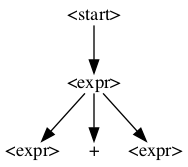

In [182]:
display_tree(derivation_tree)

In [151]:
import gstbook

In [152]:
import re
import random

In [153]:
from Grammars import START_SYMBOL, RE_SYMBOL, EXPR_GRAMMAR, symbols

In [154]:
def init_tree(start_symbol=START_SYMBOL):
    return (start_symbol, None)

In [155]:
def is_symbol(s):
    return re.match(RE_SYMBOL, s)

In [156]:
assert is_symbol("<abc>")
assert not is_symbol("+")

In [194]:
def expansion_to_children(expansion):
    # print("Converting " + repr(expansion))
    # strings contains all substrings -- both terminals and non-terminals such
    # that ''.join(strings) == expansion
    strings  = re.split(RE_SYMBOL, expansion)
    return [(s, None) if is_symbol(s) else (s, []) for s in strings if len(s) > 0]

In [200]:
expansion_to_children("<term> + <expr>")

[('<term>', None), (' + ', []), ('<expr>', None)]

In [159]:
def symbol_min_cost(nt, grammar, seen=set()):
    expansions = grammar[nt]
    return min(min_expansions(e, grammar, seen | {nt}) for e in expansions)

In [160]:
def min_expansions(expansion, grammar, seen=set()):
    syms = symbols(expansion)
    # at least one expansion has no variable to expand.
    if len(syms) == 0:
        return 1

    # if a variable present in the expansion is already in the stack, then it is
    # recursion
    if any(s in seen for s in syms): return float('inf')
    # the value of a expansion is the sum of all expandable variables inside + 1
    return sum(symbol_min_cost(s, grammar, seen) for s in syms) + 1

In [161]:
def expand_node(node, grammar, prefer_shortest_expansion):
    (symbol, children) = node
    # print("Expanding " + repr(symbol))
    assert children is None

    # Fetch the possible expansions from grammar...
    expansions = grammar[symbol]

    possible_children_with_len = [(expansion_to_children(expansion),
                                   min_expansions(expansion, grammar, {symbol}))
                                  for expansion in expansions]
    min_len = min(s[1] for s in possible_children_with_len)

    # ...as well as the shortest ones
    shortest_children = [child for (child, clen) in possible_children_with_len
                               if clen == min_len]

    # Pick a child randomly
    if prefer_shortest_expansion:
        children = random.choice(shortest_children)
    else:
        # TODO: Consider preferring children not expanded yet,
        # and other forms of grammar coverage (or code coverage)
        children, _ = random.choice(possible_children_with_len)

    # Return with a new list
    return (symbol, children)

In [162]:
def possible_expansions(tree):
    (symbol, children) = tree
    if children is None:
        return 1

    number_of_expansions = sum(possible_expansions(c) for c in children)
    return number_of_expansions

In [163]:
def any_possible_expansions(tree):
    (symbol, children) = tree
    if children is None: return True

    return any(any_possible_expansions(c) for c in children)

In [164]:
def expand_tree_once(tree, grammar, prefer_shortest_expansion):
    (symbol, children) = tree
    if children is None:
        # Expand this node
        return expand_node(tree, grammar, prefer_shortest_expansion)

    # print("Expanding tree " + repr(tree))

    # Find all children with possible expansions
    expandable_children = [i for (i, c) in enumerate(children) if any_possible_expansions(c)]

    # Select a random child
    # TODO: Various heuristics for choosing a child here,
    # e.g. grammar or code coverage
    child_to_be_expanded = random.choice(expandable_children)

    # Expand it
    new_child = expand_tree_once(children[child_to_be_expanded], grammar, prefer_shortest_expansion)

    new_children = (children[:child_to_be_expanded] +
                    [new_child] +
                    children[child_to_be_expanded + 1:])

    new_tree = (symbol, new_children)

    # print("Expanding tree " + repr(tree) + " into " + repr(new_tree))

    return new_tree

In [165]:
def expand_tree(tree, grammar, max_symbols):
    # Stage 1: Expand until we reach the max number of symbols
    while 0 < possible_expansions(tree) < max_symbols:
        tree = expand_tree_once(tree, grammar, False)

    # Stage 2: Keep on expanding, but now focus on the shortest expansions
    while any_possible_expansions(tree):
        tree = expand_tree_once(tree, grammar, True)

    return tree

In [166]:
def all_terminals(tree):
    (symbol, children) = tree
    if children is None:
        # This is a nonterminal symbol not expanded yet
        return symbol

    if len(children) == 0:
        # This is a terminal symbol
        return symbol

    # This is an expanded symbol:
    # Concatenate all terminal symbols from all children
    return ''.join([all_terminals(c) for c in children])

In [186]:
def produce(grammar, max_symbols=10, start_symbol=START_SYMBOL, disp=False, log=False):
    # Create an initial derivation tree
    tree = init_tree(start_symbol)
    # print(tree)

    # Expand all nonterminals
    tree = expand_tree(tree, grammar, max_symbols)
    if disp:
        display(display_tree(tree))
    if log:
        print(tree)

    # Return the string
    return all_terminals(tree)

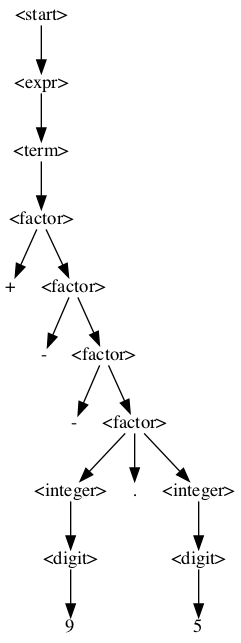

+--9.5


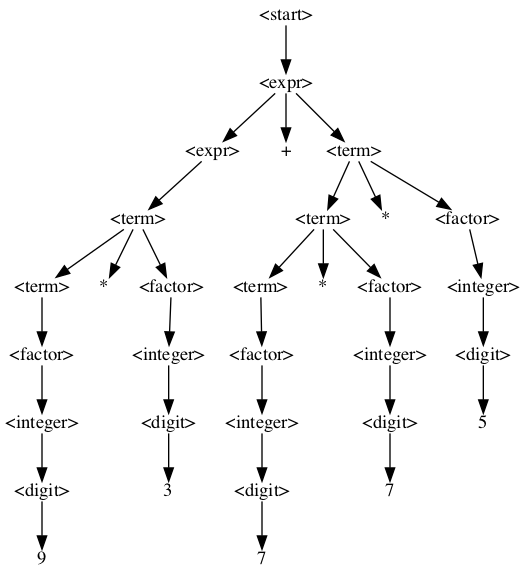

9 * 3 + 7 * 7 * 5


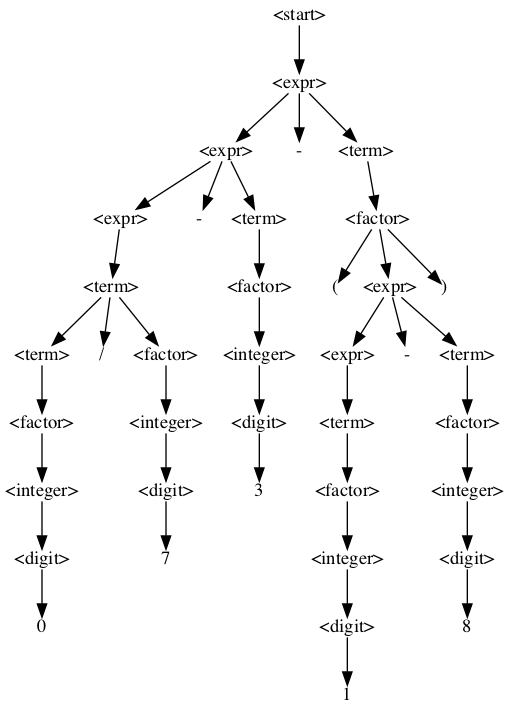

0 / 7 - 3 - (1 - 8)


In [202]:
for i in range(3):
    print(produce(EXPR_GRAMMAR, max_symbols=5, disp=True))

## Lessons Learned

* _Lesson one_
* _Lesson two_
* _Lesson three_

## Next Steps

_Link to subsequent chapters (notebooks) here, as in:_

* [use _mutations_ on existing inputs to get more valid inputs](Mutation_Fuzzing.ipynb)
* [use _grammars_ (i.e., a specification of the input format) to get even more valid inputs](Grammars.ipynb)
* [reduce _failing inputs_ for efficient debugging](Reducing.ipynb)


## Exercises

_Close the chapter with a few exercises such that people have things to do.  Use the Jupyter `Exercise2` nbextension to add solutions that can be interactively viewed or hidden.  (Alternatively, just copy the exercise and solution cells below with their metadata.)  We will set up things such that solutions do not appear in the PDF and HTML formats._

### Exercise 1


_Solution for the exercise_